In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold,cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import lightgbm as lgb
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../Real_Umbilo.csv', sep=';',decimal=',')
df.set_index('Dia', inplace=True)

df

,Q_entrada,NH_entrada,TSS_entrada,DQO_entrada,DBO_entrada,TN_entrada,TP_entrada,DQO_saida,Nitrato_saida,Amonia_saida
Dia,,,,,,,,,,
0,4719.000000,21.000000,271.000000,391.000000,198.575000,34.060000,8.020000,33.0,10.8,0.6
1,5866.458829,22.000327,276.000327,399.999347,203.059809,35.360294,8.099990,35.0,12.0,0.5
2,5358.157069,23.998870,281.996233,406.995103,206.957307,37.558734,8.149966,37.0,14.0,0.5
3,5266.313109,22.999791,278.000209,401.000418,203.710285,36.399787,8.109998,39.0,14.0,0.5
4,6671.931586,21.000432,274.999568,396.999136,201.824410,34.220441,8.060004,41.0,14.0,0.5
...,...,...,...,...,...,...,...,...,...,...
360,5120.341705,20.998558,184.998558,266.997116,135.395000,29.898501,6.929986,36.0,12.6,2.1
361,5587.915779,22.000000,182.001170,263.000000,134.093479,30.780012,6.900000,36.0,12.8,1.7
362,5984.690649,22.998229,179.999646,259.000354,131.495253,31.668215,6.869996,37.0,13.0,1.4


In [3]:
y = df['DQO_saida']
X = df.drop(['DQO_saida',
            'Nitrato_saida',
            'Amonia_saida',
            'TP_entrada',
            'DQO_entrada',
            'DBO_entrada',], axis=1)

print("X", X.shape)
print("y", y.shape)

X (365, 4)
y (365,)


In [4]:
seed = 42

# separando treino e teste
X_training, X_test, y_training, y_test = train_test_split(X, y, shuffle=False, test_size=0.082) 
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Test set X (30, 4)
Test set y (30,)


In [5]:
# Padronização (Standardization) para o y
# Sempre usar os dados de treino apenas para construir o modelo, então transformar o teste com base no treino (como se o teste fossem dados novos)
y_train = np.array(y_training).reshape(len(y_training),1)
y_testing = np.array(y_test).reshape(len(y_test),1)

scalery = StandardScaler().fit(y_train)
normalized_y_train = pd.DataFrame(
    scalery.transform(y_train),
    columns = [y_training.name],
    index = y_training.index
)
normalized_y_train = normalized_y_train.squeeze()

normalized_y_test = pd.DataFrame(
    scalery.transform(y_testing),
    columns = [y_test.name],
    index = y_test.index
)
normalized_y_test = normalized_y_test.squeeze()


# Padronização dos previsores (DataFrame X)
scalerX = StandardScaler().fit(X_training)

normalized_x_train = pd.DataFrame(
    scalerX.transform(X_training),
    columns = X_training.columns,
    index = X_training.index
)


normalized_x_test = pd.DataFrame(
    scalerX.transform(X_test),
    columns = X_test.columns,
    index = X_test.index
)

In [6]:
# Epsilon-Support Vector Regression com validação cruzada e Grid Search

# definindo os valores possíveis dos parâmetros a serem testados
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'degree': [x for x in range(2,5,1)],
          'tol': [1e-4],
          'C': [0.5,1,2,3,5],
          'epsilon': [0.01,0.05,0.1,0.5,1]
        } 
          # coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True

# criando o objeto do modelo com SVR
svr_model_cv_gs = SVR()

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(svr_model_cv_gs, param_grid=params, return_train_score=True, scoring='neg_mean_absolute_percentage_error')

# treinando o modelo com o grid search
grid_search.fit(normalized_x_train, normalized_y_train)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# pegando e imprimindo a melhor combinação de hiperparâmetros
cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)



 Best hyperparameters:
{'C': 0.5, 'degree': 4, 'epsilon': 0.5, 'kernel': 'poly', 'tol': 0.0001}


In [7]:
# imprimindo o score médio nas bases de treino
print("Average accuracy on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))

# imprimindo o score médio nas bases de validação
print("Average accuracy on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0]))

# configurando o modelo com a melhor combinação de hiperparâmetros
svr_model_cv_gs.set_params(
                           degree = cv_best_params['degree']
                           )

# treinando um modelo com a melhor combinação de hiperparâmetros
svr_model_cv_gs.fit(normalized_x_train, normalized_y_train)
best_model_params = svr_model_cv_gs.get_params()

Average accuracy on train set: -3.566 +/- 1.919
Average accuracy on validation set: -2.840 +/- 1.427


In [8]:
# Realizando a predição no teste
y_test_pred_svr = svr_model_cv_gs.predict(normalized_x_test)

# Desnormalização
y_test_pred_svr = np.array(y_test_pred_svr).reshape(len(y_test_pred_svr),1)
y_test_pred_svr = scalery.inverse_transform(y_test_pred_svr)
y_test_pred_svr = pd.DataFrame(y_test_pred_svr, columns=[normalized_y_test.name], index = normalized_y_test.index)
y_test_pred_svr = y_test_pred_svr.squeeze()

y_test_pred_svr


# Análise dos erros das previsões
rmse_test_svr = math.sqrt(mean_squared_error(y_test, y_test_pred_svr))
mae_test_svr = mean_absolute_error(y_test, y_test_pred_svr)
mape_test_svr = mean_absolute_percentage_error(y_test, y_test_pred_svr)
r2_test_svr = r2_score(y_test, y_test_pred_svr)


df_metricas = pd.DataFrame(data={'RSME':[rmse_test_svr], 'MAE':[mae_test_svr], 'MAPE':[mape_test_svr],'R²':[r2_test_svr]})
df_metricas

,RSME,MAE,MAPE,R²
0,15.31443,11.527564,0.188615,0.603728


In [9]:
# Cross-validation para averiguar precisão do modelo na base de treino
print('---------Treino---------')
results = cross_val_score(svr_model_cv_gs,X=X_training,y=y_training,cv=KFold(n_splits=10), scoring='neg_mean_absolute_percentage_error')*(-1)
print(results)
print('Média: {}\nStd: {}'.format(round(results.mean(),4),round(results.std(),4)))
print('---------Total---------')
# Predição analisada por validação cruzada para o dataset inteiro
results_total = cross_val_score(svr_model_cv_gs,X=X,y=y,cv=KFold(n_splits=10), scoring='neg_mean_absolute_percentage_error')*(-1)
print(results_total)
print('Média: {}\nStd: {}'.format(round(results_total.mean(),4),round(results_total.std(),4)))

---------Treino---------
[0.69609676 0.25475351 0.22468103 0.15245415 0.32895175 0.20179218
 0.22393498 0.32951296 0.23167045 0.22969039]


Média: 0.2874
Std: 0.1454
---------Total---------
[0.6400373  0.22828285 0.19428014 0.16880509 0.35434605 0.16197683
 0.30709497 0.27033002 0.25998524 0.4194333 ]
Média: 0.3005
Std: 0.1371


In [10]:
# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia

df_comparacao = pd.concat([y_test,y_test_pred_svr],axis=1)
df_comparacao.columns = ['Valor_Real','Valor_Predito']
df_comparacao['Diferenca_percentual'] = 100*(df_comparacao['Valor_Predito'] - df_comparacao['Valor_Real'])/df_comparacao['Valor_Real']
df_comparacao.sort_index(inplace=True)
df_comparacao

,Valor_Real,Valor_Predito,Diferenca_percentual
Dia,,,
335,75.0,72.297494,-3.603341
336,92.0,95.313843,3.602003
337,71.0,89.841636,26.537515
338,59.0,88.953453,50.768564
339,73.0,95.898362,31.367619
340,87.0,85.737248,-1.451439
341,101.0,78.874193,-21.906739
342,126.0,81.775045,-35.099171
343,60.0,88.474992,47.458320


       RSME        MAE      MAPE        R²
0  15.31443  11.527564  0.188615  0.603728


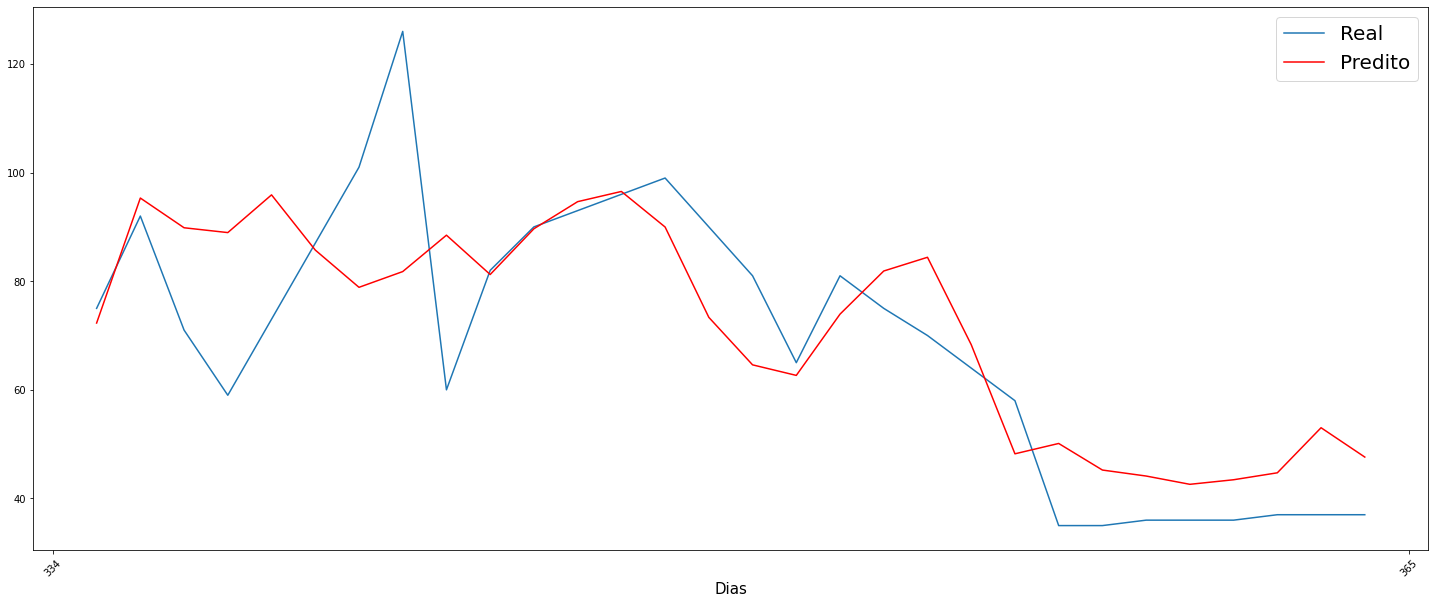

In [11]:
print(df_metricas)
import matplotlib.dates as mdates
# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_comparacao.index, df_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_comparacao.index, df_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [12]:
# Saving predictions

df_comparacao.to_csv("1_2-Previsoes_SVM.csv", encoding='utf-8-sig',sep=';',decimal=',')

# Previsão na base de treino

        RSME        MAE      MAPE        R²
0  36.692902  20.450808  0.203113  0.175771


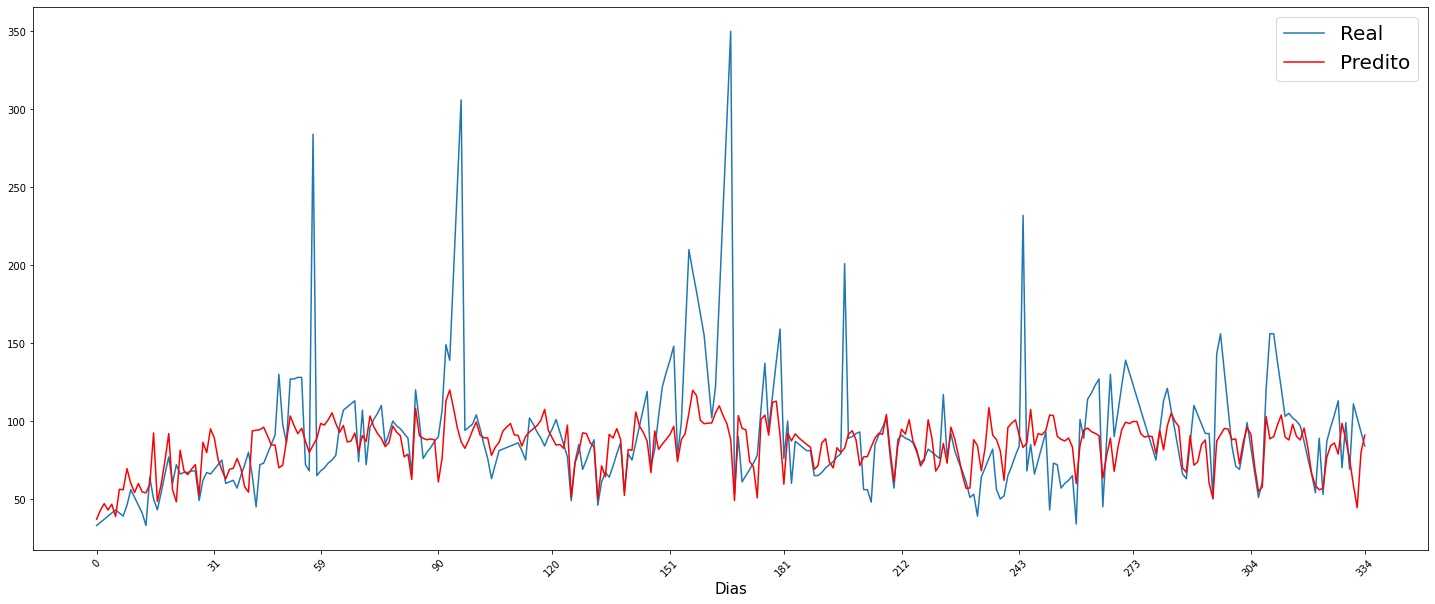

In [13]:
# Realizando a predição no traine
y_train_pred_rf = svr_model_cv_gs.predict(normalized_x_train)

# Desnormalização
y_train_pred_rf = np.array(y_train_pred_rf).reshape(len(y_train_pred_rf),1)
y_train_pred_rf = scalery.inverse_transform(y_train_pred_rf)
y_train_pred_rf = pd.DataFrame(y_train_pred_rf, columns=[normalized_y_train.name], index = normalized_y_train.index)
y_train_pred_rf = y_train_pred_rf.squeeze()

y_train_pred_rf


# Análise dos erros das previsões
rmse_train_rf = math.sqrt(mean_squared_error(y_train, y_train_pred_rf))
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
mape_train_rf = mean_absolute_percentage_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia
df_train_comparacao = pd.concat([y_training,y_train_pred_rf],axis=1)
df_train_comparacao.columns = ['Valor_Real','Valor_Predito']
df_train_comparacao['Diferenca_percentual'] = 100*(df_train_comparacao['Valor_Predito'] - df_train_comparacao['Valor_Real'])/df_train_comparacao['Valor_Real']
df_train_comparacao.sort_index(inplace=True)
df_train_comparacao


df_train_metricas = pd.DataFrame(data={'RSME':[rmse_train_rf], 'MAE':[mae_train_rf], 'MAPE':[mape_train_rf],'R²':[r2_train_rf]})
print(df_train_metricas)

# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [14]:
# Gráfico de cima, queremos os dados só para o melhor modelo (base de treino)
df_train_comparacao.to_csv('2_2-Previsoes_TREINO_SVM.csv',sep=';',decimal=',',encoding='utf-8-sig')

# FEATURE IMPORTANCE

## PDPs and Permutation Importance

In [15]:
print(normalized_x_train.min())
print(normalized_x_train.max())

Q_entrada     -2.727095
NH_entrada    -2.605314
TSS_entrada   -2.494750
TN_entrada    -2.588871
dtype: float64
Q_entrada      2.838441
NH_entrada     6.840331
TSS_entrada    4.629701
TN_entrada     4.368140
dtype: float64


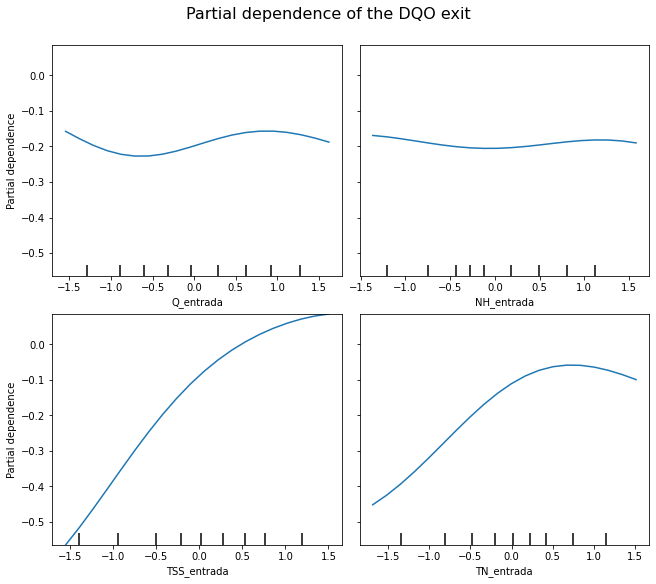

In [16]:
from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

# print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": X_training.columns,
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    # "categorical_features": categorical_features,
}

_, ax = plt.subplots(ncols=2, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    svr_model_cv_gs,
    normalized_x_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(
    "Partial dependence of the DQO exit\n",
    fontsize=16,
)

Tree-based models provide an alternative measure of feature importances based on the mean decrease in impurity (MDI). Impurity is quantified by the splitting criterion of the decision trees (Gini, Log Loss or Mean Squared Error). However, this method can give high importance to features that may not be predictive on unseen data when the model is overfitting. Permutation-based feature importance, on the other hand, avoids this issue, since it can be computed on unseen data.Furthermore, impurity-based feature importance for trees are strongly biased and favor high cardinality features (typically numerical features) over low cardinality features such as binary features or categorical variables with a small number of possible categories.
Permutation-based feature importances do not exhibit such a bias. Additionally, the permutation feature importance may be computed performance metric on the model predictions and can be used to analyze any model class (not just tree-based models).

,Importance_mean,Importance_std,Importance_mean_normalized
TSS_entrada,0.141303,0.026621,0.468823
TN_entrada,0.069389,0.019070,0.230223
Q_entrada,0.064527,0.010952,0.214092
NH_entrada,0.026180,0.014638,0.086862


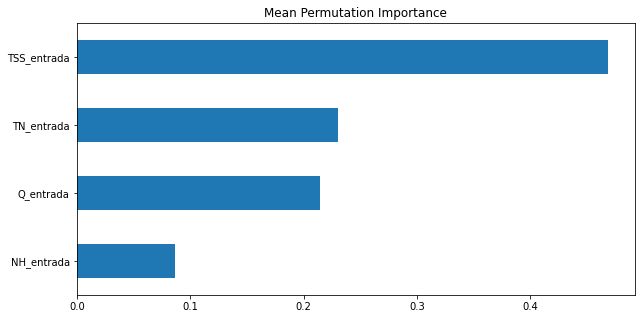

In [17]:

from sklearn.inspection import permutation_importance
r = permutation_importance(svr_model_cv_gs, normalized_x_train, normalized_y_train,
                           n_repeats=30,
                           random_state=0)
# r.importances_mean
# r.importances_std

df_permutation_importance = pd.DataFrame(
    data={'Importance_mean': r.importances_mean,
          'Importance_std': r.importances_std},
    index=normalized_x_train.columns
)

df_permutation_importance['Importance_mean_normalized'] = df_permutation_importance['Importance_mean']/df_permutation_importance['Importance_mean'].sum()

df_permutation_importance = df_permutation_importance.sort_values('Importance_mean',ascending=False)

df_permutation_importance['Importance_mean_normalized'].sort_values(ascending=True).plot.barh(figsize=(10,5), title='Mean Permutation Importance')

df_permutation_importance

In [18]:
df_permutation_importance.to_csv('3_2-Permutation_Importance_SVM.csv',sep=';',decimal=',',encoding='utf-8-sig')

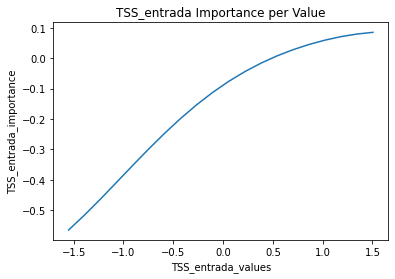

,Q_entrada_importance,Q_entrada_values,NH_entrada_importance,NH_entrada_values,TSS_entrada_importance,TSS_entrada_values,TN_entrada_importance,TN_entrada_values
0,-0.157312,-1.545764,-0.168892,-1.365209,-0.564960,-1.551337,-0.451865,-1.681477
1,-0.178131,-1.379149,-0.172741,-1.210232,-0.515521,-1.390468,-0.425054,-1.513572
2,-0.196791,-1.212533,-0.177948,-1.055255,-0.462671,-1.229599,-0.393893,-1.345666
3,-0.211783,-1.045917,-0.183932,-0.900279,-0.407914,-1.068730,-0.359099,-1.177761
4,-0.222031,-0.879302,-0.190070,-0.745302,-0.352746,-0.907861,-0.321635,-1.009856
5,-0.226989,-0.712686,-0.195756,-0.590325,-0.298562,-0.746992,-0.282670,-0.841950
6,-0.226673,-0.546070,-0.200451,-0.435349,-0.246577,-0.586123,-0.243511,-0.674045
7,-0.221634,-0.379454,-0.203730,-0.280372,-0.197764,-0.425254,-0.205523,-0.506140
8,-0.212863,-0.212839,-0.205324,-0.125395,-0.152823,-0.264385,-0.170032,-0.338234
9,-0.201663,-0.046223,-0.205145,0.029582,-0.112170,-0.103516,-0.138234,-0.170329


In [42]:
dict_data = {}
df_pdp = pd.DataFrame(display.pd_results[0]['average'].flatten(),columns=[X.columns[0]+'_importance'])
for i in range(len(display.pd_results)):
    dict_data[f"{X.columns[i]}_importance"] = display.pd_results[i]['average']
    dict_data[f"{X.columns[i]}_values"]  = display.pd_results[i]['values']
    # df_pdp[f"{X.columns[i]}_importance"] = dict_data[f"{X.columns[i]}_importance"].flatten()
    df_pdp[f"{X.columns[i]}_importance"] = display.pd_results[i]['average'][0]
    df_pdp[f"{X.columns[i]}_values"] = display.pd_results[i]['values'][0]


plt.plot(df_pdp.loc[:, 'TSS_entrada_values'], df_pdp.loc[:, 'TSS_entrada_importance'])
plt.xlabel('TSS_entrada_values')
plt.ylabel('TSS_entrada_importance')
plt.title('TSS_entrada Importance per Value')
plt.show()


df_pdp.to_csv('4_2-PDPs_SVM.csv',encoding='utf-8-sig',decimal=',',sep=';')
df_pdp

In [21]:
# Avaliando na base de TESTE o impacto nas métricas causado pela permutação de valores de cada uma das variáveis.
# https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
r_multi = permutation_importance(
    svr_model_cv_gs, normalized_x_test, normalized_y_test, n_repeats=30, random_state=0, scoring=scoring)

# Apenas mostrar as variáveis cujas importâncias são maiores que 2 vezes o respectivo desvio padrão (para todas as métricas)
for metric in r_multi:
    print(f"{metric}")
    r1 = r_multi[metric]
    for i in r1.importances_mean.argsort()[::-1]:
        if r1.importances_mean[i] - 2 * r1.importances_std[i] > 0:
            print(f"    {X.columns[i]}: "
                  f"{r1.importances_mean[i]:.3f}"
                  f" +/- {r1.importances_std[i]:.3f}\n")

r2
    TSS_entrada: 0.333 +/- 0.110

    TN_entrada: 0.249 +/- 0.096

    NH_entrada: 0.085 +/- 0.036

neg_mean_absolute_percentage_error
    TSS_entrada: 1.200 +/- 0.549

neg_mean_squared_error
    TSS_entrada: 0.121 +/- 0.040

    TN_entrada: 0.090 +/- 0.035

    NH_entrada: 0.031 +/- 0.013



In [22]:
# Avaliando na base de TREINO o impacto nas métricas causado pela permutação de valores de cada uma das variáveis.
# https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error'] #, 'neg_mean_absolute_error'
r_multi = permutation_importance(
    svr_model_cv_gs, normalized_x_train, normalized_y_train, n_repeats=30, random_state=0, scoring=scoring)

# Apenas mostrar as variáveis cujas importâncias são maiores que 2 vezes o respectivo desvio padrão (para todas as métricas)
for metric in r_multi:
    print(f"{metric}")
    r1 = r_multi[metric]
    for i in r1.importances_mean.argsort()[::-1]:
        if r1.importances_mean[i] - 2 * r1.importances_std[i] > 0:
            print(f"    {X.columns[i]}: "
                  f"{r1.importances_mean[i]:.3f}"
                  f" +/- {r1.importances_std[i]:.3f}")

r2
    TSS_entrada: 0.141 +/- 0.027
    TN_entrada: 0.069 +/- 0.019
    Q_entrada: 0.065 +/- 0.011
neg_mean_absolute_percentage_error
neg_mean_squared_error
    TSS_entrada: 0.141 +/- 0.027
    TN_entrada: 0.069 +/- 0.019
    Q_entrada: 0.065 +/- 0.011


## LIME - Local Interpretable Model-Agnostic Explanations 

In [23]:
# import lime
# import lime.lime_tabular

# # LIME has one explainer for all the models
# explainer = lime.lime_tabular.LimeTabularExplainer(normalized_x_train.values, feature_names=X.columns.values.tolist(),
#                                                   class_names=[y.name], verbose=True, mode='regression')
# ### Cálculo da importância de cada variável para um registro específico
# # normalized_x_test.iloc[5]
# # normalized_x_test.values[5]

# # Choose the 5th instance and use it to predict the results
# j = 5
# exp = explainer.explain_instance(normalized_x_test.iloc[j], svr_model_cv_gs.predict, num_features=4)

# # Show the predictions
# exp.show_in_notebook(show_table=True)

# exp.as_list()

In [24]:
# # Choose the 10th instance and use it to predict the results
# j = 10
# exp = explainer.explain_instance(normalized_x_test.iloc[j], svr_model_cv_gs.predict, num_features=6)

# # Show the predictions
# exp.show_in_notebook(show_table=True)

# exp.as_list()
# # Choose the LAST instance and use it to predict the results
# j = -1
# exp = explainer.explain_instance(normalized_x_test.iloc[j], svr_model_cv_gs.predict, num_features=6)

# # Show the predictions
# exp.show_in_notebook(show_table=True)

# exp.as_list()

In [25]:

# # Apply lime to last 20 observations
# from interpret.blackbox import LimeTabular
# from interpret import show


# # Initilize Lime for Tabular data
# lime = LimeTabular(model=svr_model_cv_gs, 
#                    data=normalized_x_train, 
#                    random_state=1)
# # Get local explanations
# lime_local = lime.explain_local(normalized_x_test[-20:], 
#                                 normalized_y_test[-20:], 
#                                 name='LIME')

# show(lime_local)

### Análise de Feature Importance geral com LIME ao invés de apenas para ocorrência específica

In [26]:
# import warnings
# warnings.filterwarnings("ignore")

# l=[]
# for n in range(0,normalized_x_test.shape[0]+0):
#      exp = explainer.explain_instance(normalized_x_test.values[n], svr_model_cv_gs.predict, num_features=6)
#      a=exp.as_list()
#      l.append(a)
# df_lime_importances = pd.DataFrame(l)

# for i in range(df_lime_importances.shape[1]):
#      df_lime_importances[i]= df_lime_importances[i].apply(lambda x: str(x).split(",")[1].strip(" )"))
#      # df_lime_importances[i] = df_lime_importances[i].apply(lambda x: abs(float(x)))
#      df_lime_importances[i] = df_lime_importances[i].apply(lambda x: float(x))

# df_lime_importances.columns = ['TSS','Q','NH','TN']

# df_lime_importances.head()

In [27]:
# df_lime_absolute_importances = df_lime_importances.copy()

# for i in range(df_lime_importances.shape[1]):
#     df_lime_absolute_importances.iloc[:,i] = df_lime_absolute_importances.iloc[:,i].apply(lambda x: abs(float(x)))
     
# df_lime_absolute_importances.head()

In [28]:
# # In percentage
# df_lime_absolute_importances.mean()/df_lime_absolute_importances.mean().sum()

In [29]:
# # df_lime_importances['TN'].plot()
# df_lime_importances.plot()
# df_lime_absolute_importances.plot()

### Análise de Feature Importance geral com LIME ao invés de apenas para ocorrência específica para a BASE DE TREINO

In [30]:
# l=[]
# for n in range(0,normalized_x_train.shape[0]):
#      exp = explainer.explain_instance(normalized_x_train.values[n], svr_model_cv_gs.predict, num_features=6)
#      a=exp.as_list()
#      l.append(a)
# df_lime_train_importances = pd.DataFrame(l)

# for i in range(df_lime_train_importances.shape[1]):
#      df_lime_train_importances[i]= df_lime_train_importances[i].apply(lambda x: str(x).split(",")[1].strip(" )"))
#      # df_lime_train_importances[i] = df_lime_train_importances[i].apply(lambda x: abs(float(x)))
#      df_lime_train_importances[i] = df_lime_train_importances[i].apply(lambda x: float(x))

# df_lime_train_importances.columns = ['TSS','Q','NH','TN']

# df_lime_train_importances.head()

In [31]:
# df_lime_train_absolute_importances = df_lime_train_importances.copy()

# for i in range(df_lime_importances.shape[1]):
#     df_lime_train_absolute_importances.iloc[:,i] = df_lime_train_absolute_importances.iloc[:,i].apply(lambda x: abs(float(x)))
     
# df_lime_train_absolute_importances

In [32]:
# # In percentage
# df_lime_train_absolute_importances.mean()/df_lime_train_absolute_importances.mean().sum()

In [33]:
# # df_lime_train_importances['TN'].plot()
# df_lime_train_importances.plot()
# df_lime_train_absolute_importances.plot()